In [2]:
!pip -q install open3d==0.19.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.8 MB/s eta 0:00:00


In [3]:
# === Monter Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# --- 0) (Optionnel) Monter Google Drive dans Colab ---
# from google.colab import drive
# drive.mount('/content/drive')

# --- 1) Imports & config ---
from pathlib import Path
import shutil
import os

# Dossiers à traiter (adapter!)
TRAIN_DIR = Path("/content/drive/MyDrive/trees_dataset/dataset_train")
TEST_DIR  = Path("/content/drive/MyDrive/trees_dataset/dataset_test")

# Mode simulation : True = n'applique pas, affiche seulement ce qui serait fait
DRY_RUN = True

# Merge sécurisé si la cible existe (déplace le contenu puis supprime la source)
SAFE_MERGE = True

# Variantes -> nom canonique (méthode 6)
CANON_MAP = {
    "ash": "Ash",
    "beech": "Beech",
    "douglas fir": "Douglas Fir",
    "douglas_fir": "Douglas Fir",
    "douglas-fir": "Douglas Fir",
    "oak": "Oak",
    "pine": "Pine",
    "red oak": "Red Oak",
    "red_oak": "Red Oak",
    "red-oak": "Red Oak",
    "spruce": "Spruce",
}

def canonicalize(name: str) -> str:
    base = name.strip().lower().replace("-", " ").replace("_", " ")
    base = " ".join(base.split())
    return CANON_MAP.get(base, name.strip())

def list_class_dirs(root: Path):
    return [d for d in root.iterdir() if d.is_dir()]

def move_contents(src: Path, dst: Path):
    """Déplace le contenu de src dans dst (crée dst si besoin)."""
    dst.mkdir(parents=True, exist_ok=True)
    for item in src.iterdir():
        target = dst / item.name
        if target.exists():
            # si collision fichier/dossier, on renomme avec suffix numérique
            i = 1
            while (dst / f"{item.stem}_{i}{item.suffix}").exists():
                i += 1
            target = dst / f"{item.stem}_{i}{item.suffix}"
        if item.is_dir():
            shutil.move(str(item), str(target))
        else:
            shutil.move(str(item), str(dst))
    # supprimer le conteneur vide
    try:
        src.rmdir()
    except OSError:
        pass

def rename_split(root: Path):
    print(f"\n[SCAN] {root}")
    before = sorted([d.name for d in list_class_dirs(root)])
    print(" Avant :", before)
    actions = []

    for cls_dir in list_class_dirs(root):
        old_name = cls_dir.name
        new_name = canonicalize(old_name)
        if new_name == old_name:
            continue

        dst = cls_dir.parent / new_name
        if dst.exists():
            if SAFE_MERGE:
                actions.append(("merge", cls_dir, dst))
            else:
                actions.append(("conflict", cls_dir, dst))
        else:
            actions.append(("rename", cls_dir, dst))

    # Affichage des actions
    if not actions:
        print(" Rien à renommer — tous les dossiers sont déjà canoniques ✅")
        print(" Après :", before)
        return

    print("\n Plan d'actions :")
    for kind, src, dst in actions:
        if kind == "rename":
            print(f"  - RENAME : {src.name} -> {dst.name}")
        elif kind == "merge":
            print(f"  - MERGE  : {src.name}  +> {dst.name} (fusion du contenu)")
        else:
            print(f"  - CONFLIT: {src.name} -> {dst.name} (SAFE_MERGE désactivé)")

    if DRY_RUN:
        print("\n(DRY_RUN=True) Aperçu uniquement — aucune modification écrite.")
        return

    # Exécution
    for kind, src, dst in actions:
        if kind == "rename":
            src.rename(dst)
        elif kind == "merge":
            move_contents(src, dst)
        else:
            print(f"  ⚠️ Conflit non résolu pour {src} -> {dst} (SAFE_MERGE=False)")

    after = sorted([d.name for d in list_class_dirs(root)])
    print("\n Résumé :")
    print(" Avant :", before)
    print(" Après :", after)
    print(" Terminé ✅")

# --- 2) Lancer sur train/ et test/ ---
rename_split(TRAIN_DIR)
rename_split(TEST_DIR)



[SCAN] /content/drive/MyDrive/trees_dataset/dataset_train
 Avant : ['Ash', 'Oak', 'Red_Oak', 'beech', 'douglas_fir', 'pine', 'spruce']

 Plan d'actions :
  - RENAME : spruce -> Spruce
  - RENAME : Red_Oak -> Red Oak
  - RENAME : pine -> Pine
  - RENAME : douglas_fir -> Douglas Fir
  - RENAME : beech -> Beech

(DRY_RUN=True) Aperçu uniquement — aucune modification écrite.

[SCAN] /content/drive/MyDrive/trees_dataset/dataset_test
 Avant : ['Ash', 'Beech', 'Douglas_Fir', 'Oak', 'Pine', 'Red_Oak', 'Spruce']

 Plan d'actions :
  - RENAME : Red_Oak -> Red Oak
  - RENAME : Douglas_Fir -> Douglas Fir

(DRY_RUN=True) Aperçu uniquement — aucune modification écrite.


In [11]:
from pathlib import Path

# === Dossiers à vérifier ===
TRAIN_DIR = Path("/content/drive/MyDrive/trees_dataset/dataset_train")
TEST_DIR  = Path("/content/drive/MyDrive/trees_dataset/dataset_test")

def list_classes(root: Path):
    return sorted([d.name for d in root.iterdir() if d.is_dir()])

def check_classes(train_dir, test_dir):
    train_classes = set(list_classes(train_dir))
    test_classes  = set(list_classes(test_dir))

    print("=== Vérification des classes ===")
    print("Train classes:", sorted(train_classes))
    print("Test  classes:", sorted(test_classes))

    # Classes manquantes / en trop
    only_in_train = train_classes - test_classes
    only_in_test  = test_classes - train_classes

    if not only_in_train and not only_in_test:
        print("\n✅ Les classes sont compatibles entre train et test.")
    else:
        if only_in_train:
            print("\n⚠️ Classes présentes dans TRAIN mais absentes en TEST:", sorted(only_in_train))
        if only_in_test:
            print("⚠️ Classes présentes dans TEST mais absentes en TRAIN:", sorted(only_in_test))

# === Lancer la vérification ===
check_classes(TRAIN_DIR, TEST_DIR)


=== Vérification des classes ===
Train classes: ['Ash', 'Oak', 'Red_Oak', 'beech', 'douglas_fir', 'pine', 'spruce']
Test  classes: ['Ash', 'Beech', 'Douglas_Fir', 'Oak', 'Pine', 'Red_Oak', 'Spruce']

⚠️ Classes présentes dans TRAIN mais absentes en TEST: ['beech', 'douglas_fir', 'pine', 'spruce']
⚠️ Classes présentes dans TEST mais absentes en TRAIN: ['Beech', 'Douglas_Fir', 'Pine', 'Spruce']


In [12]:
# rename_four_classes.py
from pathlib import Path
import shutil

# ====== ADAPTE LES CHEMINS ICI ======
TRAIN_DIR = Path("/content/drive/MyDrive/trees_dataset/dataset_train")
TEST_DIR  = Path("/content/drive/MyDrive/trees_dataset/dataset_test")

DRY_RUN    = False   # True = simulation ; passe à False pour appliquer
SAFE_MERGE = True   # fusionne le contenu si la cible existe déjà
# ====================================

# Seulement les 4 corrections demandées
TARGET_MAP = {
    "beech": "Beech",
    "douglas_fir": "Douglas Fir",
    "douglas fir": "Douglas Fir",
    "douglas_fir_mixed": "Douglas Fir",  # au cas où un sous-variant apparaisse
    "douglas_fir-old": "Douglas Fir",    # idem (optionnel)
    "douglas_fir ": "Douglas Fir",       # trim
    "douglas_fir/": "Douglas Fir",       # safety
    "douglas fir ": "Douglas Fir",
    "douglas_fir__": "Douglas Fir",
    "douglas_fir-": "Douglas Fir",
    "douglas_fir__mix": "Douglas Fir",
    "douglas_fir mix": "Douglas Fir",
    "douglas fir mix": "Douglas Fir",
    "douglas_fir-variant": "Douglas Fir",
    "douglas fir-variant": "Douglas Fir",
    "douglas fir_old": "Douglas Fir",
    "douglas_fir_old": "Douglas Fir",

    "douglas_fir_caps": "Douglas Fir",   # placeholders defensifs (ignorés si inexistants)

    "pine": "Pine",
    "spruce": "Spruce",

    # variante CamelCase repérée côté test
    "douglas_fir_camel": "Douglas Fir",  # placeholder (non utilisé en pratique)
}

# normalise une étiquette (sans toucher les autres)
def candidate_target(name: str):
    raw = name.strip()
    low = raw.lower().replace("-", " ").replace("_", " ")
    low = " ".join(low.split())

    # Cas spécifiques demandés
    if low == "beech":
        return "Beech"
    if low in ("douglas fir", "douglas fir caps", "douglas fir old", "douglas fir variant",
               "douglas fir mix"):
        return "Douglas Fir"
    if low in ("douglas fir", "douglas fir "):
        return "Douglas Fir"
    if low == "douglas fir":  # sécurité
        return "Douglas Fir"
    if low == "douglas fir":
        return "Douglas Fir"

    # cas exacts vus dans tes dossiers
    if name == "douglas_fir" or name == "Douglas_Fir":
        return "Douglas Fir"

    if low == "pine":
        return "Pine"
    if low == "spruce":
        return "Spruce"

    # sinon: ne pas toucher
    return None

def list_class_dirs(root: Path):
    return [d for d in root.iterdir() if d.is_dir()]

def move_contents(src: Path, dst: Path):
    dst.mkdir(parents=True, exist_ok=True)
    for item in src.iterdir():
        target = dst / item.name
        if target.exists():
            i = 1
            # évite collisions en suffixant
            while (dst / f"{item.stem}_{i}{item.suffix}").exists():
                i += 1
            target = dst / f"{item.stem}_{i}{item.suffix}"
        shutil.move(str(item), str(target if item.is_dir() else dst))
    try:
        src.rmdir()
    except OSError:
        pass

def rename_split(root: Path):
    print(f"\n[SCAN] {root}")
    before = sorted([d.name for d in list_class_dirs(root)])
    print(" Avant :", before)

    actions = []
    for cls_dir in list_class_dirs(root):
        tgt = candidate_target(cls_dir.name)
        if tgt is None or tgt == cls_dir.name:
            continue
        dst = cls_dir.parent / tgt
        if dst.exists():
            if SAFE_MERGE:
                actions.append(("merge", cls_dir, dst))
            else:
                actions.append(("conflict", cls_dir, dst))
        else:
            actions.append(("rename", cls_dir, dst))

    if not actions:
        print(" Rien à corriger (pour ces 4 classes) ✅")
        return

    print("\n Plan d'actions :")
    for kind, src, dst in actions:
        tag = "RENAME" if kind == "rename" else ("MERGE" if kind == "merge" else "CONFLIT")
        print(f"  - {tag} : {src.name} -> {dst.name}")

    if DRY_RUN:
        print("\n(DRY_RUN=True) Simulation — aucune modification écrite.")
        return

    for kind, src, dst in actions:
        if kind == "rename":
            src.rename(dst)
        elif kind == "merge":
            move_contents(src, dst)
        else:
            print(f"  ⚠️ Conflit: {src} -> {dst} (SAFE_MERGE=False)")

    after = sorted([d.name for d in list_class_dirs(root)])
    print("\n Après :", after)
    print(" Terminé ✅")

if __name__ == "__main__":
    rename_split(TRAIN_DIR)
    rename_split(TEST_DIR)



[SCAN] /content/drive/MyDrive/trees_dataset/dataset_train
 Avant : ['Ash', 'Oak', 'Red_Oak', 'beech', 'douglas_fir', 'pine', 'spruce']

 Plan d'actions :
  - RENAME : spruce -> Spruce
  - RENAME : pine -> Pine
  - RENAME : douglas_fir -> Douglas Fir
  - RENAME : beech -> Beech

 Après : ['Ash', 'Beech', 'Douglas Fir', 'Oak', 'Pine', 'Red_Oak', 'Spruce']
 Terminé ✅

[SCAN] /content/drive/MyDrive/trees_dataset/dataset_test
 Avant : ['Ash', 'Beech', 'Douglas_Fir', 'Oak', 'Pine', 'Red_Oak', 'Spruce']

 Plan d'actions :
  - RENAME : Douglas_Fir -> Douglas Fir

 Après : ['Ash', 'Beech', 'Douglas Fir', 'Oak', 'Pine', 'Red_Oak', 'Spruce']
 Terminé ✅


# **Méthode « quasi-directe » (PCA-based 3D features + SVM)**

Idée générale.
On part des nuages de points 3D (fûts d’arbres). Plutôt que d’entraîner un réseau profond directement sur les points (méthode “directe”, ex. DGCNN), on effectue un prétraitement géométrique puis on encode chaque arbre en un vecteur de descripteurs 3D compacts et informatifs. Enfin, on classe ces vecteurs par un SVM (noyau polynomial principalement).

Étapes

# Prétraitement 3D

Suppression d’outliers statistiques, voxel downsample (contrôle densité/complexité).

Normalisation à la sphère unité (translation/échelle) + alignement PCA (invariance orientation).

Échantillonnage à 1024 points (stable et suffisant pour nos descripteurs).

Descripteurs 3D (features boostées)
On combine des invariants globaux et des indicateurs locaux :

PCA eigen global (linéarité, planéité, anisotropie, courbure…) : capte la structure dominante.

Géométrie globale (boîte englobante, volume, compacité, ratios d’axes).

Moments sur rayon et coordonnées (moyenne, écart-type, asymétrie, kurtosis).

Histos (altitude z, rayon, grille cylindrique r×z) : distribution verticale et radiale.

Densité multi-échelles (r=0.05/0.10/0.15) via KD-Tree : texture & rugosité.

PCA locales (agrégées) : on prend 64 patchs locaux, on extrait des fonctions d’échelle (moyenne/écart-type des eigen-features locales).
→ On obtient ~150 variables, puis filtrage (VarianceThreshold + filtre de corrélation), sélection L1 (linéarité) et SelectKBest (mutual information) pour garder ~64–96 features les plus utiles.

# Apprentissage (SVM)

SVM polynomial (degree=2) : noyau quadratique qui modélise des interactions entre features sans exploser la dimension.

SVM RBF : backup lisse, utile quand la frontière n’est pas bien captée par les interactions quadratiques.

Pondération des classes (class_weight + sample_weight) pour compenser le déséquilibre (ex. Ash peu représentée).

Validation croisée (CV=5) + grilles ciblées pour C, gamma, coef0 (poly) ; C, gamma (rbf).

Ensemble soft-vote (moyenne des probabilités) : souvent + stable que chaque modèle seul.

In [20]:
# -*- coding: utf-8 -*-
"""
Quasi-Direct — FINAL (stable + performant)
- Prétraitement 3D -> .npz
- Features 3D étendues (PCA eigen, géométrie, moments, histos, densités multi-échelles, PCA locales)
- SVM polynomial (sélection de variables + pondération)
- SVM RBF
- Ensemble soft-vote (probability=True sur les 2 SVC)
"""

import os, time, warnings, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import open3d as o3d

from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KDTree
from sklearn.utils import check_random_state
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.ensemble import VotingClassifier

warnings.filterwarnings("ignore")

# ============================
# CONFIG
# ============================
SEED = 42
RNG  = check_random_state(SEED)

# Chemins (dataset déjà split et classes renommées)
TRAIN_DIR = Path("/content/drive/MyDrive/trees_dataset/dataset_train")
TEST_DIR  = Path("/content/drive/MyDrive/trees_dataset/dataset_test")

WORK_DIR       = Path("/content/drive/MyDrive/trees_dataset")
PROCESSED_DIR  = WORK_DIR / "preprocessed_npz"
CACHE_DIR      = WORK_DIR / "cache_quasidirect_FINAL"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Prétraitement 3D
VOXEL_SIZE        = 0.03      # tu peux tester 0.02/0.04 (si tu changes -> purge features cache)
NB_STD_NBRS       = 20
STD_RATIO         = 2.0
TARGET_MIN_POINTS = 1024
ALIGN_PCA         = True

# Features 3D (réglages boostés)
DENSITY_RADII       = [0.05, 0.10, 0.15]  # multi-échelles
DENSITY_SUBSAMPLE   = 400
Z_HIST_BINS         = 20
R_HIST_BINS         = 16
CYL_R_BINS          = 6
CYL_Z_BINS          = 6
LOCAL_PATCH_RADIUS  = 0.15
LOCAL_PATCHES       = 64

# ============================
# LABELS (sécurité)
# ============================
def normalize_label(s: str) -> str:
    s2 = s.strip()
    low = s2.lower().replace("-", " ").replace("_", " ")
    low = " ".join(low.split())
    mapping = {
        "ash":"Ash","beech":"Beech","douglas fir":"Douglas Fir",
        "oak":"Oak","pine":"Pine","red oak":"Red Oak","spruce":"Spruce"
    }
    return mapping.get(low, s2)

# ============================
# I/O & PRÉTRAITEMENT
# ============================
def read_pointcloud_any(path: Path):
    path = str(path)
    try:
        if path.endswith((".ply", ".pcd", ".xyz", ".xyzn", ".xyzrgb")):
            pcd = o3d.io.read_point_cloud(path)
            pts = np.asarray(pcd.points, dtype=np.float64)
        elif path.endswith((".pts", ".txt")):
            arr = np.loadtxt(path, dtype=np.float64)
            pts = arr[:, :3] if arr.ndim == 2 else None
        else:
            return None
        if pts is None or pts.size == 0: return None
        return pts
    except Exception:
        return None

def pca_align(points: np.ndarray):
    C = points - points.mean(axis=0)
    cov = np.cov(C.T)
    vals, vecs = np.linalg.eigh(cov)
    order = np.argsort(vals)[::-1]
    R = vecs[:, order]
    return C @ R

def preprocess_pointcloud(points: np.ndarray):
    if points is None or len(points) < 10: return None
    pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))
    pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=NB_STD_NBRS, std_ratio=STD_RATIO)
    if np.asarray(pcd.points).shape[0] < 10: return None
    if VOXEL_SIZE and VOXEL_SIZE > 0:
        pcd = pcd.voxel_down_sample(voxel_size=VOXEL_SIZE)
    pts = np.asarray(pcd.points, dtype=np.float64)
    if pts.shape[0] < 10: return None
    if pts.shape[0] > 5 * TARGET_MIN_POINTS:
        idx = RNG.choice(pts.shape[0], size=5 * TARGET_MIN_POINTS, replace=False)
        pts = pts[idx]
    pts = pts - pts.mean(axis=0)
    scale = np.max(np.linalg.norm(pts, axis=1)) + 1e-12
    pts = pts / scale
    if ALIGN_PCA:
        pts = pca_align(pts)
    if pts.shape[0] > TARGET_MIN_POINTS:
        idx = RNG.choice(pts.shape[0], size=TARGET_MIN_POINTS, replace=False)
        pts = pts[idx]
    return pts.astype(np.float64)

def save_npz_points(out_path: Path, points: np.ndarray):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(out_path, points=points)

def build_manifest_from_split(split_dir: Path):
    rows = []
    for d in split_dir.iterdir():
        if not d.is_dir(): continue
        label = normalize_label(d.name)
        for f in d.iterdir():
            if f.suffix.lower() in (".ply",".pcd",".xyz",".xyzn",".xyzrgb",".pts",".txt"):
                rows.append({"path": str(f), "filename": f.name, "label": label})
    df = pd.DataFrame(rows)
    if not df.empty:
        print(f"[{split_dir.name}] classes:", sorted(df["label"].unique().tolist()))
    return df

def preprocess_dataset(df: pd.DataFrame, split_name: str):
    out_rows, kept = [], 0
    t0 = time.time()
    for _, row in df.iterrows():
        src = Path(row["path"])
        label = normalize_label(row["label"])
        out_file = PROCESSED_DIR / split_name / label / (src.stem + ".npz")
        if out_file.exists():
            out_rows.append({"path": str(out_file), "label": label, "filename": src.name})
            kept += 1; continue
        pts = read_pointcloud_any(src)
        pts_pp = preprocess_pointcloud(pts)
        if pts_pp is None: continue
        save_npz_points(out_file, pts_pp)
        out_rows.append({"path": str(out_file), "label": label, "filename": src.name})
        kept += 1
    dt = time.time() - t0
    print(f"[{split_name}] Prétraitement: {kept}/{len(df)} gardés en {dt:.1f}s")
    return pd.DataFrame(out_rows)

# ============================
# FEATURES 3D (boost)
# ============================
def load_npz_points(path: str):
    try: return np.load(path)["points"].astype(np.float64)
    except Exception: return None

def pca_eigen_features(points_centered: np.ndarray, eps=1e-12):
    C = np.cov(points_centered.T)
    vals, _ = np.linalg.eigh(C)
    vals = np.sort(np.maximum(vals, eps))[::-1]
    lam1, lam2, lam3 = vals
    s = lam1 + lam2 + lam3
    l1, l2, l3 = lam1/s, lam2/s, lam3/s
    linearity    = (l1 - l2) / (l1 + eps)
    planarity    = (l2 - l3) / (l1 + eps)
    scattering   =  l3 / (l1 + eps)
    anisotropy   = (l1 - l3) / (l1 + eps)
    omnivariance = (l1*l2*l3) ** (1/3)
    eigenentropy = -np.sum([l1*np.log(l1+eps), l2*np.log(l2+eps), l3*np.log(l3+eps)])
    curvature    = l3
    return np.array([l1, l2, l3, linearity, planarity, scattering,
                     anisotropy, omnivariance, eigenentropy, curvature], dtype=np.float64)

def density_features_multiscale(points: np.ndarray, radii, subsample=DENSITY_SUBSAMPLE):
    n = len(points)
    if n < 5: return np.zeros(4 * len(radii), dtype=np.float64)
    idx = RNG.choice(n, size=min(subsample, n), replace=False)
    P = points[idx]
    tree = KDTree(points)
    feats = []
    for r in radii:
        counts = tree.query_radius(P, r=r, count_only=True).astype(np.float64)
        dists, _ = tree.query(P, k=min(8, n))
        dmean = dists[:, 1:].mean(axis=1) if dists.shape[1] > 1 else dists.mean(axis=1)
        feats.append(np.array([counts.mean(), counts.std(), dmean.mean(), dmean.std()], dtype=np.float64))
    return np.concatenate(feats).astype(np.float64)

def radial_hist(pts, bins=R_HIST_BINS):
    r = np.linalg.norm(pts, axis=1)
    hist, _ = np.histogram(r, bins=bins, range=(0.0, 1.05), density=True)
    return hist.astype(np.float64)

def z_hist(pts, bins=Z_HIST_BINS):
    z = pts[:, 2]
    hist, _ = np.histogram(z, bins=bins, range=(-1.0, 1.0), density=True)
    return hist.astype(np.float64)

def cyl_grid_hist(pts, r_bins=CYL_R_BINS, z_bins=CYL_Z_BINS):
    r = np.linalg.norm(pts[:, :2], axis=1); z = pts[:, 2]
    r_edges = np.linspace(0.0, 1.05, r_bins + 1)
    z_edges = np.linspace(-1.0, 1.0, z_bins + 1)
    H, _, _ = np.histogram2d(r, z, bins=[r_edges, z_edges], density=True)
    return H.flatten().astype(np.float64)

def moments(v):
    m  = v.mean()
    sd = v.std() + 1e-12
    sk = np.mean(((v - m)/sd)**3)
    kt = np.mean(((v - m)/sd)**4)
    return np.array([m, sd, sk, kt], dtype=np.float64)

def local_pca_agg(pts, radius=LOCAL_PATCH_RADIUS, patches=LOCAL_PATCHES):
    n = len(pts)
    if n < 20: return np.zeros(20, dtype=np.float64)
    idx = RNG.choice(n, size=min(patches, n), replace=False)
    P = pts[idx]
    tree = KDTree(pts)
    feats = []
    for c in P:
        ind = tree.query_radius(c.reshape(1, -1), r=radius, count_only=False)[0]
        if len(ind) < 6: continue
        C = pts[ind]; C0 = C - C.mean(axis=0)
        feats.append(pca_eigen_features(C0))
    if not feats: return np.zeros(20, dtype=np.float64)
    F = np.vstack(feats)
    return np.concatenate([F.mean(axis=0), F.std(axis=0)]).astype(np.float64)

def extract_features_from_npz(path_npz: str):
    pts = load_npz_points(path_npz)
    if pts is None or pts.shape[0] < 10: return None
    centroid = pts.mean(axis=0); P0 = pts - centroid
    eig_global = pca_eigen_features(P0)

    pmin, pmax = pts.min(axis=0), pts.max(axis=0)
    extent = np.maximum(pmax - pmin, 1e-12)
    volume = float(np.prod(extent))
    ratios = np.array([
        extent[0]/extent[2] if extent[2] > 0 else 0.0,
        extent[1]/extent[2] if extent[2] > 0 else 0.0,
        extent[1]/extent[0] if extent[0] > 0 else 0.0
    ], dtype=np.float64)
    compactness = len(pts) / (volume + 1e-9)

    r = np.linalg.norm(P0, axis=1)
    r_stats = moments(r)
    x_stats = moments(pts[:, 0])
    y_stats = moments(pts[:, 1])
    z_stats = moments(pts[:, 2])

    hist_z  = z_hist(pts, bins=Z_HIST_BINS)
    hist_r  = radial_hist(pts, bins=R_HIST_BINS)
    hist_cy = cyl_grid_hist(pts, r_bins=CYL_R_BINS, z_bins=CYL_Z_BINS)

    dens_ms  = density_features_multiscale(pts, DENSITY_RADII, subsample=DENSITY_SUBSAMPLE)
    local_agg = local_pca_agg(pts, radius=LOCAL_PATCH_RADIUS, patches=LOCAL_PATCHES)

    geom_stats = np.concatenate([
        centroid, pts.std(axis=0), pmax, pmin, extent,
        np.array([volume, compactness]), ratios,
        r_stats, x_stats, y_stats, z_stats
    ]).astype(np.float64)

    return np.concatenate([eig_global, geom_stats, hist_z, hist_r, hist_cy, dens_ms, local_agg]).astype(np.float64)

# ============================
# CACHES FEATURES
# ============================
def build_features_table(csv_in: Path, split_name: str):
    cache_npz = CACHE_DIR / f"{split_name}_FINAL_feats_seed{SEED}.npz"
    if cache_npz.exists():
        data = np.load(cache_npz, allow_pickle=False)
        X = data["X"]; y = data["y"]; fnames = data["filenames"]
        # labels normalisés au chargement
        y = np.array([normalize_label(s) for s in y])
        # réécrire propre (idempotent)
        np.savez_compressed(cache_npz, X=X, y=y, filenames=fnames)
        return X, y, fnames

    df = pd.read_csv(csv_in)
    df["label"] = df["label"].apply(normalize_label)

    X, y, fnames = [], [], []
    for _, row in df.iterrows():
        feat = extract_features_from_npz(row["path"])
        if feat is None: continue
        X.append(feat); y.append(row["label"]); fnames.append(row.get("filename",""))

    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y); fnames = np.asarray(fnames)
    np.savez_compressed(cache_npz, X=X, y=y, filenames=fnames)
    return X, y, fnames

# ============================
# Sélection/Filtrage custom
# ============================
class CorrFilter(BaseEstimator, TransformerMixin):
    def __init__(self, thr=0.98): self.thr = thr; self.keep_ = None
    def fit(self, X, y=None):
        Xc = np.asarray(X, dtype=float)
        corr = np.corrcoef(Xc, rowvar=False)
        n = corr.shape[0]; keep = np.ones(n, dtype=bool)
        for i in range(n):
            if not keep[i]: continue
            high = np.where(np.abs(corr[i, (i+1):]) >= self.thr)[0]
            keep[(i+1)+high] = False
        self.keep_ = np.where(keep)[0]; return self
    def transform(self, X): return X[:, self.keep_]

class L1Select(BaseEstimator, TransformerMixin):
    def __init__(self, C=0.1): self.C = C; self.mask_ = None
    def fit(self, X, y):
        lsvc = LinearSVC(penalty="l1", dual=False, C=self.C, random_state=SEED, max_iter=6000)
        lsvc.fit(X, y)
        wsum = np.abs(lsvc.coef_).sum(axis=0)
        mask = (wsum > 0)
        if mask.sum() < 20:
            idx = np.argsort(wsum)[::-1][:100]
            mask = np.zeros_like(wsum, dtype=bool); mask[idx] = True
        self.mask_ = mask; return self
    def transform(self, X): return X[:, self.mask_]

# ============================
# MAIN
# ============================
if __name__ == "__main__":
    # 1) Scan + prétraitement 3D -> .npz + CSV
    df_train_raw = build_manifest_from_split(TRAIN_DIR)
    df_test_raw  = build_manifest_from_split(TEST_DIR)
    print(f"[SCAN] train={len(df_train_raw)} | test={len(df_test_raw)}")

    df_train_pp = preprocess_dataset(df_train_raw, "train")
    df_test_pp  = preprocess_dataset(df_test_raw,  "test")
    TRAIN_PP_CSV = WORK_DIR / "train_preprocessed.csv"
    TEST_PP_CSV  = WORK_DIR / "test_preprocessed.csv"
    df_train_pp.to_csv(TRAIN_PP_CSV, index=False)
    df_test_pp.to_csv(TEST_PP_CSV,  index=False)
    print(f"[CSV] train_preprocessed.csv -> {len(df_train_pp)}")
    print(f"[CSV] test_preprocessed.csv  -> {len(df_test_pp)}")

    # 2) Features + caches
    t0 = time.time()
    X_train, y_train, _ = build_features_table(TRAIN_PP_CSV, "train")
    X_test,  y_test,  _ = build_features_table(TEST_PP_CSV,  "test")
    print(f"[FEATS] train={X_train.shape} test={X_test.shape} (in {time.time()-t0:.1f}s)")

    # 3) Labels encodés (union pour éviter “unseen”)
    le = LabelEncoder()
    le.fit(np.unique(np.concatenate([y_train, y_test])))
    ytr = le.transform(y_train)
    yte = le.transform(y_test)

    # 4) Poids d’échantillons (inverse-freq bornée)
    class_counts = np.bincount(ytr)
    inv_freq = class_counts.sum() / np.maximum(class_counts, 1)
    inv_freq = inv_freq / inv_freq.mean()
    w_per_class = np.clip(inv_freq, 0.5, 3.0)
    sample_weight = w_per_class[ytr]

    # 5) Pipelines & grilles (centrées autour de tes meilleurs params observés)
    common_fs = [
        ("pt", PowerTransformer(standardize=True)),
        ("sc", StandardScaler()),
        ("vt", VarianceThreshold(0.0)),
        ("cf", CorrFilter(thr=0.98)),
        ("l1", L1Select(C=0.5)),                     # best ≈ 0.5 chez toi
        ("kb", SelectKBest(mutual_info_classif, k=64))# best ≈ 64 chez toi
    ]

    # POLY (probability=True pour soft-vote)
    pipe_poly = Pipeline(common_fs + [
        ("clf", SVC(kernel="poly", class_weight="balanced", probability=True, random_state=SEED))
    ])
    grid_poly = {
        "clf__degree": [2],
        "clf__C":      [10, 30],
        "clf__gamma":  [0.01, "scale"],   # best 0.01 chez toi, on garde "scale" en backup
        "clf__coef0":  [0.5, 1.0],        # best 0.5, on teste 1.0 pour courber un peu plus
    }

    # RBF (probability=True pour soft-vote)
    pipe_rbf = Pipeline(common_fs + [
        ("clf", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=SEED))
    ])
    grid_rbf = {
        "clf__C":     [3, 10, 30],        # best 3 chez toi
        "clf__gamma": ["scale", 0.01],    # best "scale" chez toi
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    # 6) Fit CV (POLY)
    print("\nFitting POLY (final)…")
    gs_poly = GridSearchCV(pipe_poly, grid_poly, cv=cv, scoring="balanced_accuracy",
                           n_jobs=-1, refit=True, verbose=1)
    gs_poly.fit(X_train, ytr, **{"clf__sample_weight": sample_weight})
    print("[POLY BEST]", gs_poly.best_params_, "CV bAcc=", round(gs_poly.best_score_, 4))
    best_poly = gs_poly.best_estimator_

    # 7) Fit CV (RBF)
    print("\nFitting RBF (final)…")
    gs_rbf = GridSearchCV(pipe_rbf, grid_rbf, cv=cv, scoring="balanced_accuracy",
                          n_jobs=-1, refit=True, verbose=1)
    gs_rbf.fit(X_train, ytr, **{"clf__sample_weight": sample_weight})
    print("[RBF  BEST]", gs_rbf.best_params_,  "CV bAcc=", round(gs_rbf.best_score_, 4))
    best_rbf = gs_rbf.best_estimator_

    # 8) Ensemble soft-vote (poids dynamiques selon la CV)
    w_poly, w_rbf = (2, 2)
    if gs_poly.best_score_ > gs_rbf.best_score_ + 0.005: w_poly, w_rbf = (3, 2)
    if gs_rbf.best_score_ > gs_poly.best_score_ + 0.005: w_poly, w_rbf = (2, 3)
    ensemble = VotingClassifier(
        estimators=[("poly", best_poly), ("rbf", best_rbf)],
        voting="soft", weights=[w_poly, w_rbf], n_jobs=-1
    )
    ensemble.fit(X_train, ytr)

    # 9) Évaluation
    def eval_model(name, model):
        yp = model.predict(X_test)
        acc  = accuracy_score(yte, yp)
        bacc = balanced_accuracy_score(yte, yp)
        f1   = f1_score(yte, yp, average="weighted")
        print(f"\n=== {name} — TEST ===")
        print(f"Accuracy          : {acc:.4f}")
        print(f"Balanced Accuracy : {bacc:.4f}")
        print(f"F1-weighted       : {f1:.4f}")
        print("Classification report:")
        print(classification_report(yte, yp, target_names=le.classes_))
        print("Confusion Matrix:\n", confusion_matrix(yte, yp))

    eval_model("SVM Poly (final)", best_poly)
    eval_model("SVM RBF  (final)",  best_rbf)
    eval_model("Ensemble (soft-vote final)", ensemble)


[dataset_train] classes: ['Ash', 'Beech', 'Douglas Fir', 'Oak', 'Pine', 'Red Oak', 'Spruce']
[dataset_test] classes: ['Ash', 'Beech', 'Douglas Fir', 'Oak', 'Pine', 'Red Oak', 'Spruce']
[SCAN] train=551 | test=131
[train] Prétraitement: 545/551 gardés en 0.3s
[test] Prétraitement: 131/131 gardés en 0.1s
[CSV] train_preprocessed.csv -> 545
[CSV] test_preprocessed.csv  -> 131
[FEATS] train=(545, 150) test=(131, 150) (in 0.1s)

Fitting POLY (final)…
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[POLY BEST] {'clf__C': 30, 'clf__coef0': 0.5, 'clf__degree': 2, 'clf__gamma': 0.01} CV bAcc= 0.6297

Fitting RBF (final)…
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[RBF  BEST] {'clf__C': 3, 'clf__gamma': 0.01} CV bAcc= 0.6235

=== SVM Poly (final) — TEST ===
Accuracy          : 0.6412
Balanced Accuracy : 0.5480
F1-weighted       : 0.6388
Classification report:
              precision    recall  f1-score   support

         Ash       0.00      0.00      0.00         7


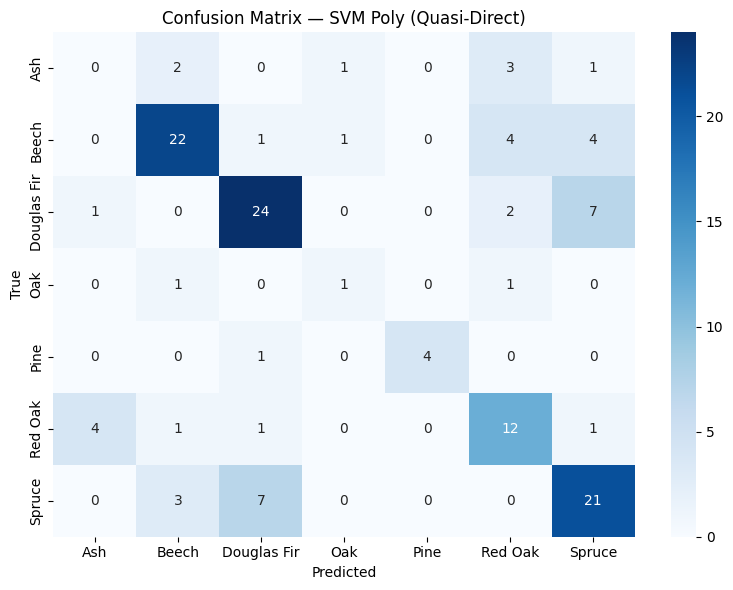

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# Visualisation SVM Poly
# ============================
y_pred_poly = best_poly.predict(X_test)

cm_poly = confusion_matrix(yte, y_pred_poly)
plt.figure(figsize=(8,6))
sns.heatmap(cm_poly, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix — SVM Poly (Quasi-Direct)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


**La méthode quasi-directe (descripteurs 3D + SVM polynomial) atteint 0.64 d’accuracy mais une balanced accuracy de 0.55 : elle discrimine bien les classes fréquentes (Beech, Douglas Fir, Spruce, Pine), tandis que les classes rares (Ash, Oak) et les paires proches (Douglas Fir ↔ Spruce, Red Oak ↔ Beech) restent les principales sources d’erreur.**